# Logistic Regression for Toxic Comment Classification
This notebook implements a multi-label logistic regression classifier with:
- Text preprocessing and cleaning
- TF-IDF vectorization with n-grams
- 6 binary classifiers (one per label)
- Cross-validation and hyperparameter tuning
- Comprehensive evaluation metrics

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, hamming_loss
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Data

In [2]:
# Load training and test data
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test_1.csv')

print(f"Train samples: {len(train_data):,}")
print(f"Test samples: {len(test_data):,}")

# Define label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Extract features and labels
X_train = train_data['comment_text']
y_train = train_data[label_cols]

X_test = test_data['comment_text']
y_test = test_data[label_cols]

print(f"\nLabel distribution in training set:")
for col in label_cols:
    count = y_train[col].sum()
    pct = (count / len(y_train)) * 100
    print(f"{col:14s}: {count:6d} ({pct:5.2f}%)")

Train samples: 159,571
Test samples: 63,978

Label distribution in training set:
toxic         :  15294 ( 9.58%)
severe_toxic  :   1595 ( 1.00%)
obscene       :   8449 ( 5.29%)
threat        :    478 ( 0.30%)
insult        :   7877 ( 4.94%)
identity_hate :   1405 ( 0.88%)


## 2. Text Preprocessing
Clean and normalize the text data

In [3]:
def preprocess_text(text):
    """
    Preprocess text for vectorization:
    - Convert to lowercase
    - Remove IP addresses and user handles
    - Remove extra whitespace
    - Keep punctuation (can be important for toxicity detection)
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove IP addresses
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)
    
    # Remove newlines and tabs
    text = re.sub(r'[\n\t]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
print("Preprocessing text...")
X_train_clean = X_train.apply(preprocess_text)
X_test_clean = X_test.apply(preprocess_text)

# Show example
print("\nExample preprocessing:")
print(f"Original: {X_train.iloc[0][:100]}...")
print(f"Cleaned:  {X_train_clean.iloc[0][:100]}...")

Preprocessing text...

Example preprocessing:
Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't ...
Cleaned:  explanation why the edits made under my username hardcore metallica fan were reverted? they weren't ...


## 3. Vectorization
Convert text to numerical features using TF-IDF

In [4]:
# TF-IDF Vectorizer with bigrams
# Using bigrams can capture phrases like "you suck" which are important for toxicity
vectorizer = TfidfVectorizer(
    max_features=50000,      # Limit vocabulary size
    ngram_range=(1, 2),      # Use unigrams and bigrams
    min_df=3,                # Ignore terms that appear in fewer than 3 documents
    max_df=0.9,              # Ignore terms that appear in more than 90% of documents
    strip_accents='unicode',
    sublinear_tf=True        # Apply sublinear tf scaling (log)
)

print("Vectorizing text...")
X_train_vec = vectorizer.fit_transform(X_train_clean)
X_test_vec = vectorizer.transform(X_test_clean)

print(f"\nVectorized shape:")
print(f"Train: {X_train_vec.shape}")
print(f"Test:  {X_test_vec.shape}")
print(f"\nVocabulary size: {len(vectorizer.vocabulary_):,}")

Vectorizing text...

Vectorized shape:
Train: (159571, 50000)
Test:  (63978, 50000)

Vocabulary size: 50,000


## 4. Train Baseline Logistic Regression Models
Train one binary classifier per label

In [5]:
# Store models for each label
models = {}
train_scores = {}

print("Training baseline logistic regression models...\n")

for label in tqdm(label_cols, desc="Training models"):
    # Train logistic regression with L2 regularization
    # class_weight='balanced' handles class imbalance
    model = LogisticRegression(
        C=4.0,                    # Regularization strength (inverse)
        max_iter=1000,
        class_weight='balanced',  # Handle class imbalance
        solver='saga',            # Good for large datasets
        random_state=42,
        n_jobs=-1
    )
    
    # Train the model
    model.fit(X_train_vec, y_train[label])
    
    # Store the model
    models[label] = model
    
    # Calculate training ROC-AUC
    y_train_pred_proba = model.predict_proba(X_train_vec)[:, 1]
    train_auc = roc_auc_score(y_train[label], y_train_pred_proba)
    train_scores[label] = train_auc

print("\nTraining ROC-AUC scores:")
for label, score in train_scores.items():
    print(f"{label:14s}: {score:.4f}")
print(f"\nMean ROC-AUC: {np.mean(list(train_scores.values())):.4f}")

Training baseline logistic regression models...



Training models: 100%|██████████| 6/6 [09:34<00:00, 95.75s/it]


Training ROC-AUC scores:
toxic         : 0.9965
severe_toxic  : 0.9918
obscene       : 0.9966
threat        : 0.9938
insult        : 0.9936
identity_hate : 0.9912

Mean ROC-AUC: 0.9939


## 5. Hyperparameter Tuning
Use cross-validation to find optimal regularization strength

In [6]:
# Hyperparameter tuning for one label (toxic) as example
# You can extend this to all labels if desired

print("Hyperparameter tuning for 'toxic' label...\n")

param_grid = {
    'C': [0.1, 0.5, 1.0, 4.0, 10.0],  # Regularization strength
}

# Use StratifiedKFold for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', random_state=42, n_jobs=-1),
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_vec, y_train['toxic'])

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Show all results
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nAll CV results:")
print(results_df[['param_C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))

Hyperparameter tuning for 'toxic' label...

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'C': 1.0}
Best CV ROC-AUC: 0.9721

All CV results:
   param_C  mean_test_score  std_test_score
2      1.0         0.972051        0.001416
3      4.0         0.971488        0.001498
1      0.5         0.970640        0.001504
4     10.0         0.968618        0.001613
0      0.1         0.960432        0.002036


## 6. Retrain with Best Parameters (Optional)
If you want to retrain all models with tuned hyperparameters

In [ ]:
# Optionally retrain all models with the best C value found
best_C = grid_search.best_params_['C']

print(f"Retraining all models with C={best_C}...\n")

for label in tqdm(label_cols, desc="Retraining"):
    model = LogisticRegression(
        C=best_C,
        max_iter=1000,
        class_weight='balanced',
        solver='saga',
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_vec, y_train[label])
    models[label] = model

print("Retraining complete!")

## 7. Evaluate on Test Set

In [7]:
# Get predictions for all labels
test_predictions = {}
test_predictions_proba = {}

print("Generating predictions on test set...\n")

for label in label_cols:
    test_predictions[label] = models[label].predict(X_test_vec)
    test_predictions_proba[label] = models[label].predict_proba(X_test_vec)[:, 1]

# Convert to DataFrame
y_pred = pd.DataFrame(test_predictions)
y_pred_proba = pd.DataFrame(test_predictions_proba)

print("Predictions generated!")

Generating predictions on test set...

Predictions generated!


## 8. Calculate Evaluation Metrics

In [8]:
# Calculate ROC-AUC for each label
print("="*60)
print("TEST SET EVALUATION METRICS")
print("="*60)

auc_scores = {}
f1_scores = {}
precision_scores = {}
recall_scores = {}

print("\nPer-Label Metrics:")
print("-"*60)

for label in label_cols:
    # ROC-AUC
    auc = roc_auc_score(y_test[label], y_pred_proba[label])
    auc_scores[label] = auc
    
    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], y_pred[label], average='binary', zero_division=0
    )
    
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1
    
    print(f"{label:14s}: AUC={auc:.4f}  F1={f1:.4f}  Precision={precision:.4f}  Recall={recall:.4f}")

print("-"*60)
print(f"\nMean ROC-AUC:  {np.mean(list(auc_scores.values())):.4f}")
print(f"Mean F1 Score: {np.mean(list(f1_scores.values())):.4f}")

# Hamming Loss (fraction of labels incorrectly predicted)
h_loss = hamming_loss(y_test, y_pred)
print(f"\nHamming Loss:  {h_loss:.4f}")

# Subset accuracy (exact match of all labels)
subset_accuracy = (y_test.values == y_pred.values).all(axis=1).mean()
print(f"Subset Accuracy (exact match): {subset_accuracy:.4f}")

TEST SET EVALUATION METRICS

Per-Label Metrics:
------------------------------------------------------------
toxic         : AUC=0.9570  F1=0.6084  Precision=0.4627  Recall=0.8880
severe_toxic  : AUC=0.9798  F1=0.2827  Precision=0.1715  Recall=0.8038
obscene       : AUC=0.9667  F1=0.5700  Precision=0.4207  Recall=0.8835
threat        : AUC=0.9868  F1=0.0915  Precision=0.0480  Recall=0.9763
insult        : AUC=0.9608  F1=0.4902  Precision=0.3372  Recall=0.8973
identity_hate : AUC=0.9698  F1=0.1769  Precision=0.0977  Recall=0.9326
------------------------------------------------------------

Mean ROC-AUC:  0.9701
Mean F1 Score: 0.3699

Hamming Loss:  0.0783
Subset Accuracy (exact match): 0.7597


## 9. Visualize Results

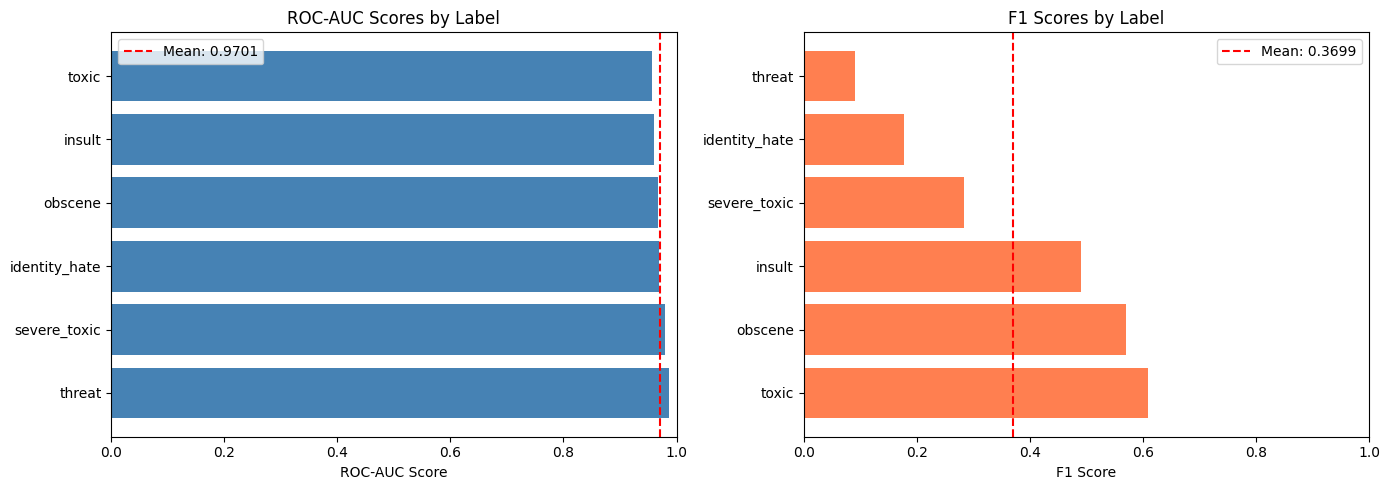

In [9]:
# Plot ROC-AUC scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC scores
ax1 = axes[0]
labels_sorted = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
labels_names = [x[0] for x in labels_sorted]
labels_values = [x[1] for x in labels_sorted]

ax1.barh(labels_names, labels_values, color='steelblue')
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('ROC-AUC Scores by Label')
ax1.axvline(x=np.mean(labels_values), color='red', linestyle='--', label=f'Mean: {np.mean(labels_values):.4f}')
ax1.legend()
ax1.set_xlim([0, 1])

# F1 scores
ax2 = axes[1]
f1_sorted = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)
f1_names = [x[0] for x in f1_sorted]
f1_values = [x[1] for x in f1_sorted]

ax2.barh(f1_names, f1_values, color='coral')
ax2.set_xlabel('F1 Score')
ax2.set_title('F1 Scores by Label')
ax2.axvline(x=np.mean(f1_values), color='red', linestyle='--', label=f'Mean: {np.mean(f1_values):.4f}')
ax2.legend()
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()

## 10. Confusion Matrices

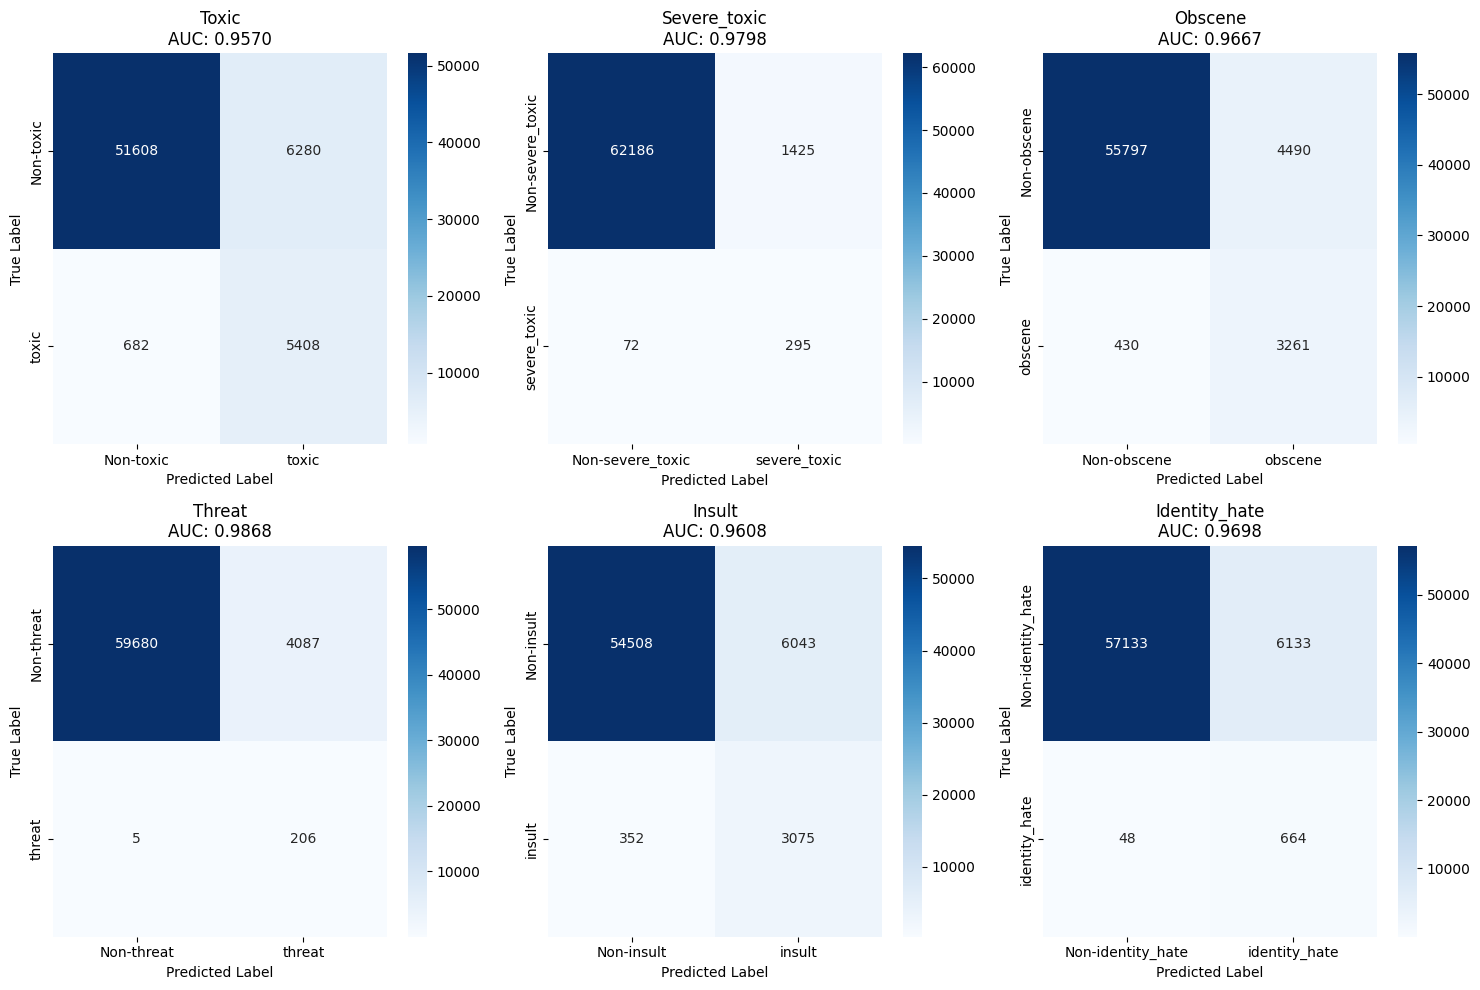

In [10]:
# Plot confusion matrices for each label
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, label in enumerate(label_cols):
    cm = confusion_matrix(y_test[label], y_pred[label])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-' + label, label],
                yticklabels=['Non-' + label, label])
    axes[idx].set_title(f'{label.capitalize()}\nAUC: {auc_scores[label]:.4f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 11. Analyze Important Features

In [11]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# For each label, show top positive and negative coefficients
def show_top_features(model, label_name, n=15):
    """
    Show the top n features with highest positive and negative coefficients
    """
    coefs = model.coef_[0]
    
    # Get top positive coefficients
    top_positive_idx = np.argsort(coefs)[-n:]
    top_positive_features = [(feature_names[i], coefs[i]) for i in top_positive_idx[::-1]]
    
    # Get top negative coefficients
    top_negative_idx = np.argsort(coefs)[:n]
    top_negative_features = [(feature_names[i], coefs[i]) for i in top_negative_idx]
    
    print(f"\n{'='*60}")
    print(f"Top features for: {label_name.upper()}")
    print(f"{'='*60}")
    
    print(f"\nMost indicative of {label_name}:")
    for feat, coef in top_positive_features:
        print(f"  {feat:30s}: {coef:8.4f}")
    
    print(f"\nMost indicative of NON-{label_name}:")
    for feat, coef in top_negative_features:
        print(f"  {feat:30s}: {coef:8.4f}")

# Show for a couple of labels
for label in ['toxic', 'obscene', 'insult']:
    show_top_features(models[label], label, n=10)


Top features for: TOXIC

Most indicative of toxic:
  fuck                          :  29.8755
  fucking                       :  28.4419
  stupid                        :  24.6360
  shit                          :  24.4509
  idiot                         :  22.4750
  bullshit                      :  20.0419
  asshole                       :  17.1986
  ass                           :  17.0258
  crap                          :  17.0021
  suck                          :  16.6807

Most indicative of NON-toxic:
  talk                          :  -5.9967
  thanks                        :  -5.2908
  thank you                     :  -5.2903
  thank                         :  -5.1924
  cheers                        :  -5.0977
  appreciate                    :  -4.9937
  please                        :  -4.8732
  best                          :  -4.7421
  redirect                      :  -4.2557
  interested                    :  -4.1906

Top features for: OBSCENE

Most indicative of obscene:
 

## 12. Error Analysis

In [12]:
# Find examples where model was most confident but wrong
def show_errors(label_name, n=5):
    """
    Show examples where the model was most confident but made errors
    """
    print(f"\n{'='*80}")
    print(f"Error Analysis for: {label_name.upper()}")
    print(f"{'='*80}")
    
    # False Positives (predicted toxic but actually not)
    false_positives = (y_pred[label_name] == 1) & (y_test[label_name] == 0)
    fp_probs = y_pred_proba[label_name][false_positives]
    
    if len(fp_probs) > 0:
        top_fp_idx = fp_probs.nlargest(n).index
        
        print(f"\nFalse Positives (predicted {label_name}, but actually not):")
        print("-"*80)
        for idx in top_fp_idx:
            prob = y_pred_proba[label_name][idx]
            text = X_test.iloc[idx]
            print(f"\nProbability: {prob:.4f}")
            print(f"Text: {text[:200]}...")
    
    # False Negatives (predicted not toxic but actually is)
    false_negatives = (y_pred[label_name] == 0) & (y_test[label_name] == 1)
    fn_probs = y_pred_proba[label_name][false_negatives]
    
    if len(fn_probs) > 0:
        top_fn_idx = fn_probs.nsmallest(n).index
        
        print(f"\nFalse Negatives (predicted NOT {label_name}, but actually is):")
        print("-"*80)
        for idx in top_fn_idx:
            prob = y_pred_proba[label_name][idx]
            text = X_test.iloc[idx]
            print(f"\nProbability: {prob:.4f}")
            print(f"Text: {text[:200]}...")

# Show errors for toxic label
show_errors('toxic', n=3)


Error Analysis for: TOXIC

False Positives (predicted toxic, but actually not):
--------------------------------------------------------------------------------

Probability: 1.0000
Text: kjgh;ohgohjx fuck u rtant...

Probability: 1.0000
Text: Pofadat befogod, NaziHungarian shit?...

Probability: 1.0000
Text: fuck u ill do whatever I fucking want boy...

False Negatives (predicted NOT toxic, but actually is):
--------------------------------------------------------------------------------

Probability: 0.0024
Text: . i was looking for the extra small condom but i couldnt find it so i was looking for a black dildo to work with but not made in asia couse it is to small there and i wanted to make her happy for once...

Probability: 0.0042
Text: == Edition request == 

 Requesting to replace File:Masturbating with a vibrator.jpg with a superior File:Woman_massages_labia_minora_and_clitoris_with_a_vibrator.jpg. It is better by all means, excep...

Probability: 0.0085
Text: FUCKI YALLLLLIta

## 13. Save Results and Models

In [13]:
# Save predictions
results = test_data[['id']].copy()
for label in label_cols:
    results[label] = y_pred_proba[label]

results.to_csv('../data/logistic_regression_predictions.csv', index=False)
print("Predictions saved to '../data/logistic_regression_predictions.csv'")

# Save evaluation metrics
metrics_df = pd.DataFrame({
    'label': label_cols,
    'roc_auc': [auc_scores[l] for l in label_cols],
    'f1_score': [f1_scores[l] for l in label_cols],
    'precision': [precision_scores[l] for l in label_cols],
    'recall': [recall_scores[l] for l in label_cols]
})

metrics_df.to_csv('../data/logistic_regression_metrics.csv', index=False)
print("Metrics saved to '../data/logistic_regression_metrics.csv'")

# Optionally save models using joblib
import joblib

# Save vectorizer
joblib.dump(vectorizer, '../data/tfidf_vectorizer.pkl')
print("Vectorizer saved to '../data/tfidf_vectorizer.pkl'")

# Save models
for label in label_cols:
    joblib.dump(models[label], f'../data/logistic_model_{label}.pkl')
print("Models saved to '../data/logistic_model_*.pkl'")

Predictions saved to '../data/logistic_regression_predictions.csv'
Metrics saved to '../data/logistic_regression_metrics.csv'
Vectorizer saved to '../data/tfidf_vectorizer.pkl'
Models saved to '../data/logistic_model_*.pkl'


## Summary

This notebook implemented a comprehensive logistic regression pipeline:

1. **Text Preprocessing**: Cleaned and normalized text
2. **Vectorization**: TF-IDF with unigrams and bigrams (50K features)
3. **Multi-label Classification**: 6 binary classifiers with class balancing
4. **Hyperparameter Tuning**: Grid search with cross-validation
5. **Evaluation**: ROC-AUC, F1, precision, recall, confusion matrices
6. **Interpretability**: Feature importance analysis
7. **Error Analysis**: Examined false positives and negatives

Key findings and considerations for the report:
- Class imbalance was handled using `class_weight='balanced'`
- TF-IDF with bigrams captures toxic phrases effectively
- Some labels (like 'threat') are harder to predict due to extreme imbalance
- Feature analysis reveals interpretable patterns (toxic words have high coefficients)